___
___
## EDA

IvanMF
___
___

In [1]:
# Librerias 
import pandas as pd
import numpy as np 
import string
import hashlib
import os

from faker import Faker
fake = Faker()
Faker.seed(420)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Necesario para ver tablas

___

In [2]:
# Lectura de archivos
# ruta relativa
ruta_raw = os.path.join("..", "data", "raw") # '..' baja un nivel...
df_procesado = {}
# print(f"📂 Buscando archivos en: {os.path.abspath(ruta_raw)}")
for archivo in os.listdir(ruta_raw):
    if archivo.endswith(".csv"):
        ruta_completa = os.path.join(ruta_raw, archivo)
        # print(f"\nCargando: {archivo} ...")
        
        try:
            # Intento 1: Carga estándar (UTF-8)
            df_temp = pd.read_csv(ruta_completa)
        except UnicodeDecodeError:
            # print("\nError de encoding UTF-8. \nIntentando con 'latin-1'")
            # Intento 2: Carga para archivos con tildes/ñ generados en Windows
            df_temp = pd.read_csv(ruta_completa, encoding='latin-1')
            
        # Guardamos en el diccionario
        df_procesado[archivo] = df_temp
        
        # Mostramos dimensiones y primeras filas
        print(f"\nDimensiones: {archivo}\n{df_temp.shape}")
        # display(df_temp.head(3)) # Usamos display() para ver la tabla formateada
    
df_procesado = pd.concat(df_procesado.values(), ignore_index=True)
print(df_procesado.info())


Dimensiones: 3.-Acumulado tiempos_2024.1.csv
(1044329, 32)

Dimensiones: 3.-Acumulado tiempos_2024.2.csv
(607987, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652316 entries, 0 to 1652315
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Login ID                      1652316 non-null  int64 
 1   Nombre del RAC                1652316 non-null  object
 2   Split/Skill                   1652316 non-null  object
 3   Fecha                         1652316 non-null  object
 4   Tiempo Inicio                 1652316 non-null  object
 5   Tiempo Fin                    1652316 non-null  object
 6   Llamadas Recibidas            1652316 non-null  int64 
 7   Llamadas abandonas            1652316 non-null  int64 
 8   Llamadas Atendidas            1652316 non-null  int64 
 9   Llamadas Transferidas         1652316 non-null  int64 
 10  Tiempo Total Ring             1652316 non-n

___
#### **Tratamiento de datos**

In [ ]:
# =========================================================
# 1. ANONIMIZACIÓN (AGENTES Y SKILLS)
# =========================================================
print("[+] Anonimizando datos sensibles...")

# --- A) AGENTES ---
# Verificamos que la columna exista antes de procesar
if 'Nombre del RAC' in df_procesado.columns:
    nombres_unicos = df_procesado['Nombre del RAC'].unique()
    mapa_agentes = {nombre: f"Agente_{i+1:04d}" for i, nombre in enumerate(nombres_unicos)}
    df_procesado['Agente_ID'] = df_procesado['Nombre del RAC'].map(mapa_agentes)

# --- B) SKILLS ---
if 'Split/Skill' in df_procesado.columns:
    skills_unicos = df_procesado['Split/Skill'].unique()
    skills_unicos.sort()

    letras = list(string.ascii_uppercase)
    def get_skill_label(i):
        if i < 26: return f"Skill_{letras[i]}"
        return f"Skill_{letras[i//26 - 1]}{letras[i%26]}"

    mapa_skills = {skill: get_skill_label(i) for i, skill in enumerate(skills_unicos)}
    df_procesado['Skill_ID'] = df_procesado['Split/Skill'].map(mapa_skills)
    
    # print("Matriz de Skills:", list(mapa_skills.items())[:3])

# --- C) BORRADO DE ORIGINALES ---
# Usamos errors='ignore' por si corres la celda dos veces no falle
df_procesado.drop(columns=['Nombre del RAC', 'Login ID', 'Split/Skill'], inplace=True, errors='ignore')

print("[+] Anonimización completa.")

# =========================================================
# 2. LIMPIEZA DE FECHAS
# =========================================================
print("[+] Ajustando Fechas y KPIs...")

# Corrección de fecha
df_procesado['Fecha'] = pd.to_datetime(df_procesado['Fecha'], errors='coerce')

# KPIS
# Cálculo de AHT (Feature Engineering)
# Suma de tiempos productivos
df_procesado['Total_Handle_Time'] = (
    df_procesado['Tiempo Total de Conversación'] + 
    df_procesado['Tiempo Total Hold'] + 
    df_procesado['Tiempo Total ACW']
)

# Cálculo seguro de AHT (evitando división por cero)
df_procesado['AHT'] = np.where(
    df_procesado['Llamadas Atendidas'] > 0,
    df_procesado['Total_Handle_Time'] / df_procesado['Llamadas Atendidas'],
    0
)

# =========================================================
# 3. TRANSFORMACIÓN DE HORARIOS (Feature Engineering)
# =========================================================
print("[+] Extrayendo Franjas Horarias...")

try:
    # Extraer hora (HH)
    df_procesado['Hora'] = df_procesado['Tiempo Inicio'].astype(str).str.split(':').str[0].astype(int)
    
    # Crear etiquetas de Turno
    def etiquetar_turno(h):
        if 6 <= h < 14: return 'Matutino'     
        if 14 <= h < 22: return 'Vespertino'  
        return 'Nocturno/Mixto'

    df_procesado['Turno'] = df_procesado['Hora'].apply(etiquetar_turno)
    print("[+] Columnas 'Hora' y 'Turno' creadas.")

except Exception as e:
    print(f"[!] Error extrayendo hora: {e}")
    df_procesado['Hora'] = -1

# =========================================================
# 4. LIMPIEZA DE COLUMNAS
# =========================================================
columnas_innecesarias = [
    # 'Tiempo Inicio',          <-- LA DEJAMOS VIVA (importante para Power BI)
    'Tiempo Fin',             
    'Llamadas Transferidas',
    'Otra hora', 
    'Tiempo con personal', 
    'Tiempo Total Abandono', 
    'Tiempo Total Transferencias', 
    'Llamadas en Hold', 
    'Llamadas en ring', 
    'Tiempo Total AUX'
]

df_procesado = df_procesado.drop(columns=columnas_innecesarias, errors='ignore')

# =========================================================
# 5. EXPORTACIÓN FINAL
# =========================================================
ruta_salida = os.path.join("..", "data", "processed", "Base_ContactCenter_Master.csv")
os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)

df_procesado.to_csv(ruta_salida, index=False)

print(f"\n[+] Done!")
print(f"[+] Archivo guardado en: {ruta_salida}")
print(f"[+] Dimensiones finales: {df_procesado.shape}")
display(df_procesado.head())

🕵️‍♂️ Anonimizando datos sensibles...
✅ Anonimización completa.
🛠️ Ajustando Fechas y KPIs...
⏰ Extrayendo Franjas Horarias...
✅ Columnas 'Hora' y 'Turno' creadas.

🎉 PROCESO TERMINADO EXITOSAMENTE
💾 Archivo guardado en: ..\data\processed\Base_ContactCenter_Master.csv
📊 Dimensiones finales: (1652316, 26)


,Fecha,Tiempo Inicio,Llamadas Recibidas,Llamadas abandonas,Llamadas Atendidas,Tiempo Total Ring,Tiempo Total de Conversación,Tiempo Total Hold,Tiempo Total ACW,Tiempo Total Avail,...,AUX 6 RETRO_CALIDAD,AUX 7 MEETING,AUX 8 PERSONALES,AUX 9 FALLA APLICATIVO,Agente_ID,Skill_ID,Total_Handle_Time,AHT,Hora,Turno
0,2024-01-01,09:00,0,0,0,0,0,0,0,1661,...,0,0,0,0,Agente_0001,Skill_B,0,0.0,9,Matutino
1,2024-01-01,09:30,0,0,0,0,0,0,0,1800,...,0,0,0,0,Agente_0001,Skill_B,0,0.0,9,Matutino
2,2024-01-01,10:00,0,0,0,0,0,0,0,1800,...,0,0,0,0,Agente_0001,Skill_B,0,0.0,10,Matutino
3,2024-01-01,10:30,0,0,0,0,0,0,0,1800,...,0,0,0,0,Agente_0001,Skill_B,0,0.0,10,Matutino
4,2024-01-01,11:00,0,0,0,0,0,0,0,451,...,0,0,133,0,Agente_0001,Skill_B,0,0.0,11,Matutino


___
#### **Visualizaciones EDA**


C:\Users\Ivan Die\AppData\Local\Temp\ipykernel_9520\3732286903.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  AHT=('Total_Handle_Time', lambda x: x.sum() / df_procesado.loc[x.index, 'Llamadas Atendidas'].sum())


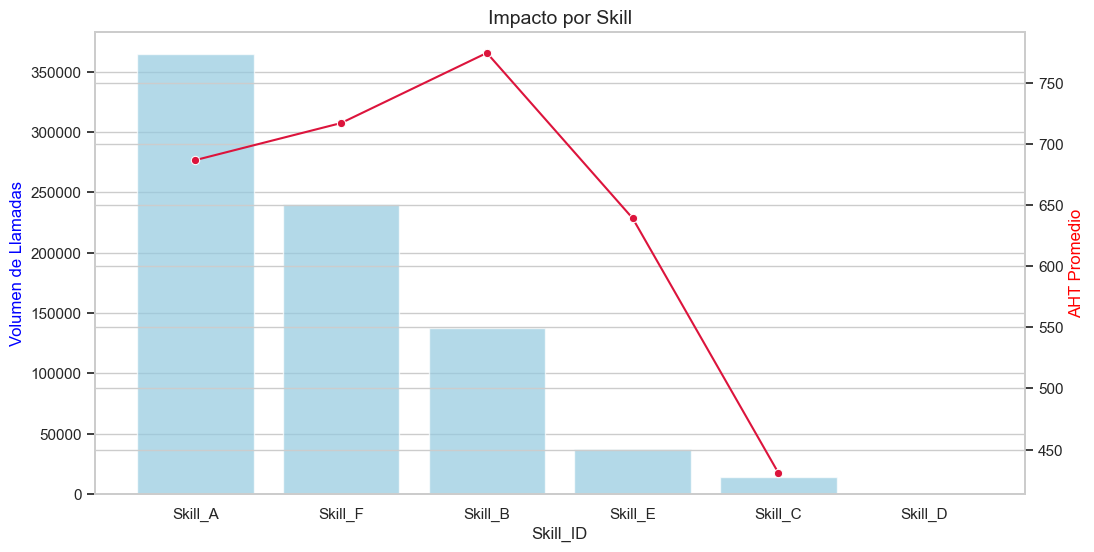

,Skill_ID,Volumen,AHT
0,Skill_A,364744,686.792246
5,Skill_F,240306,717.119781
1,Skill_B,137507,774.494578
4,Skill_E,36886,639.246327
2,Skill_C,13932,430.922050
3,Skill_D,0,inf


In [ ]:
plt.figure(figsize=(12, 6))

# 1. Calculamos volumen y AHT por Skill
skill_stats = df_procesado.groupby('Skill_ID').agg(
    Volumen=('Llamadas Atendidas', 'sum'),
    AHT=('Total_Handle_Time', lambda x: x.sum() / df_procesado.loc[x.index, 'Llamadas Atendidas'].sum())
).reset_index()

# Ordenamos por Volumen para ver los más importantes primero
skill_stats = skill_stats.sort_values('Volumen', ascending=False)

# 2. Gráfico de Doble Eje (Pareto Visual)
ax1 = sns.barplot(data=skill_stats, x='Skill_ID', y='Volumen', color='skyblue', alpha=0.7)
ax2 = ax1.twinx()
sns.lineplot(data=skill_stats, x='Skill_ID', y='AHT', color='crimson', marker='o', linewidth=3, ax=ax2)

ax1.set_ylabel('Volumen de Llamadas', color='blue')
ax2.set_ylabel('AHT Promedio', color='red')
plt.title('Impacto por Skill', fontsize=14)
plt.show()

display(skill_stats)

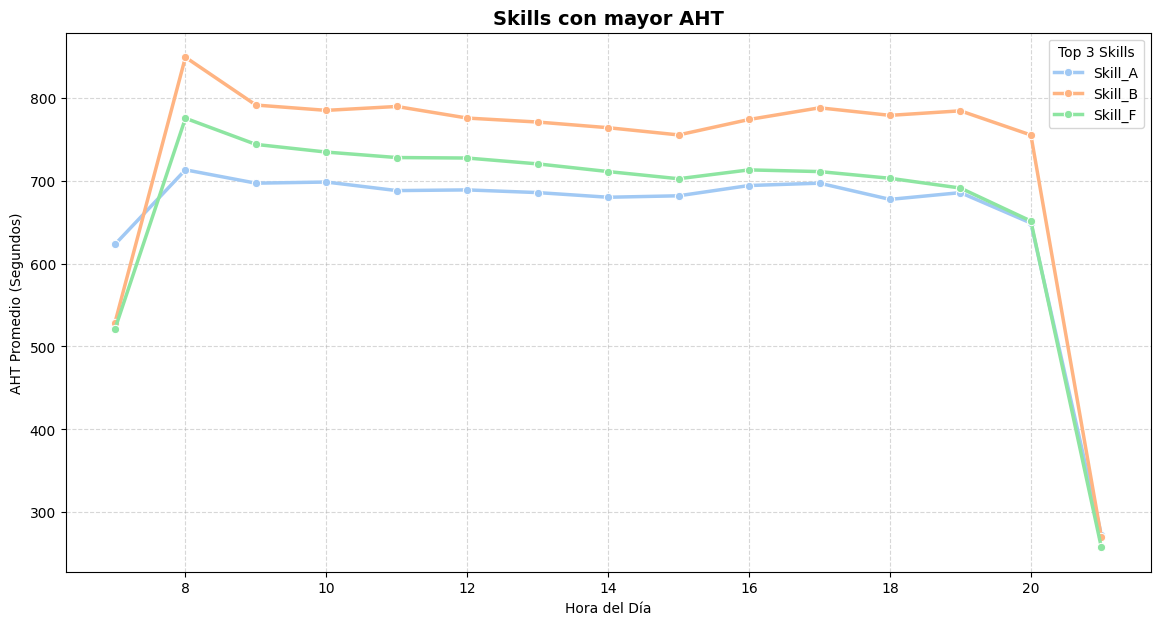

📊 Resumen de Complejidad:
   -> Skill_B: AHT Promedio Global de 130 seg
   -> Skill_A: AHT Promedio Global de 304 seg
   -> Skill_F: AHT Promedio Global de 221 seg


In [ ]:
# Configuración
plt.figure(figsize=(14, 7))

# 1. Identificar los Top 3 Skills por Volumen (para no saturar el gráfico)
top_skills = df_procesado['Skill_ID'].value_counts().head(3).index.tolist()

# 2. Filtrar solo esos skills para el gráfico
df_top_skills = df_procesado[df_procesado['Skill_ID'].isin(top_skills)]

# 3. Agrupar por Hora y Skill
perfil_skill = df_top_skills.groupby(['Hora', 'Skill_ID'])[['Total_Handle_Time', 'Llamadas Atendidas']].sum().reset_index()
perfil_skill['AHT_Skill'] = perfil_skill['Total_Handle_Time'] / perfil_skill['Llamadas Atendidas']

# 4. Gráfico de Líneas Multiserie
# hue='Skill_ID' es la magia que crea una línea de color diferente para cada Skill
sns.lineplot(data=perfil_skill, x='Hora', y='AHT_Skill', hue='Skill_ID', marker='o', linewidth=2.5, palette='pastel')

plt.title('Skills con mayor AHT', fontsize=14, fontweight='bold')
plt.ylabel('AHT Promedio (Segundos)')
plt.xlabel('Hora del Día')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Top 3 Skills')

plt.show()

# Insight automático en texto
print("📊 Resumen de Complejidad:")
for skill in top_skills:
    aht_promedio = df_top_skills[df_top_skills['Skill_ID'] == skill]['AHT'].mean()
    print(f"   -> {skill}: AHT Promedio Global de {int(aht_promedio)} seg")

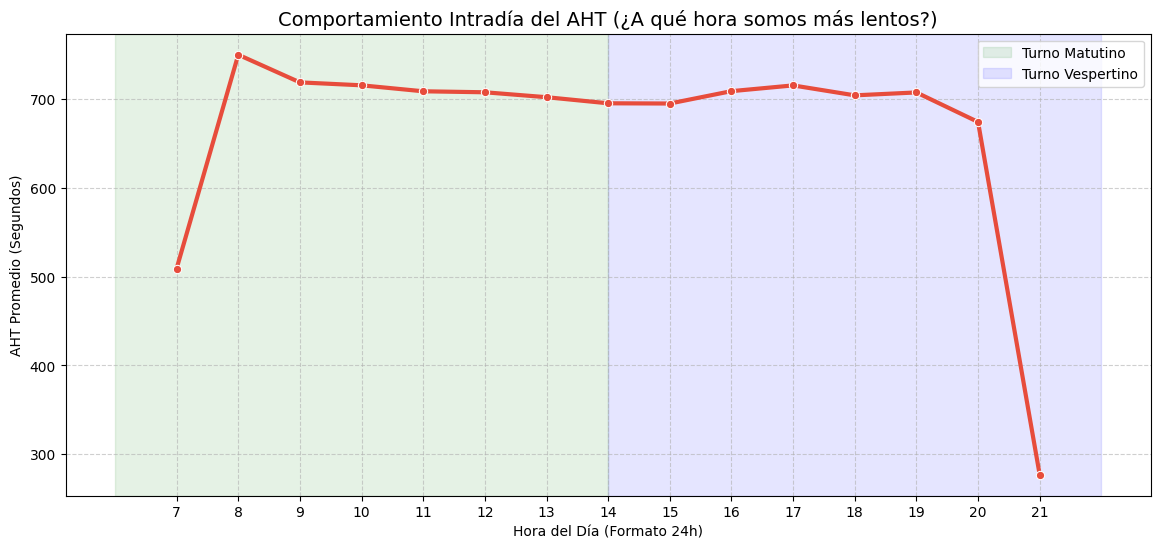

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
plt.figure(figsize=(14, 6))

# 1. Preparamos los datos: AHT promedio por Hora y Turno
# Agrupamos por Hora para ver la curva del día completo
perfil_horario = df_procesado.groupby('Hora')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
perfil_horario['AHT_Hora'] = perfil_horario['Total_Handle_Time'] / perfil_horario['Llamadas Atendidas']
perfil_horario = perfil_horario.reset_index()

# Filtramos horas de madrugada si no hay operación (ej. 0 a 6 AM) para que el gráfico se vea limpio
perfil_horario = perfil_horario[perfil_horario['Llamadas Atendidas'] > 100] 

# 2. Graficamos
sns.lineplot(data=perfil_horario, x='Hora', y='AHT_Hora', marker='o', linewidth=3, color='#e74c3c')

# Áreas sombreadas para los turnos
plt.axvspan(6, 14, color='green', alpha=0.1, label='Turno Matutino')
plt.axvspan(14, 22, color='blue', alpha=0.1, label='Turno Vespertino')

plt.title('Comportamiento Intradía del AHT (¿A qué hora somos más lentos?)', fontsize=14)
plt.ylabel('AHT Promedio (Segundos)')
plt.xlabel('Hora del Día (Formato 24h)')
plt.xticks(range(min(perfil_horario['Hora']), max(perfil_horario['Hora'])+1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

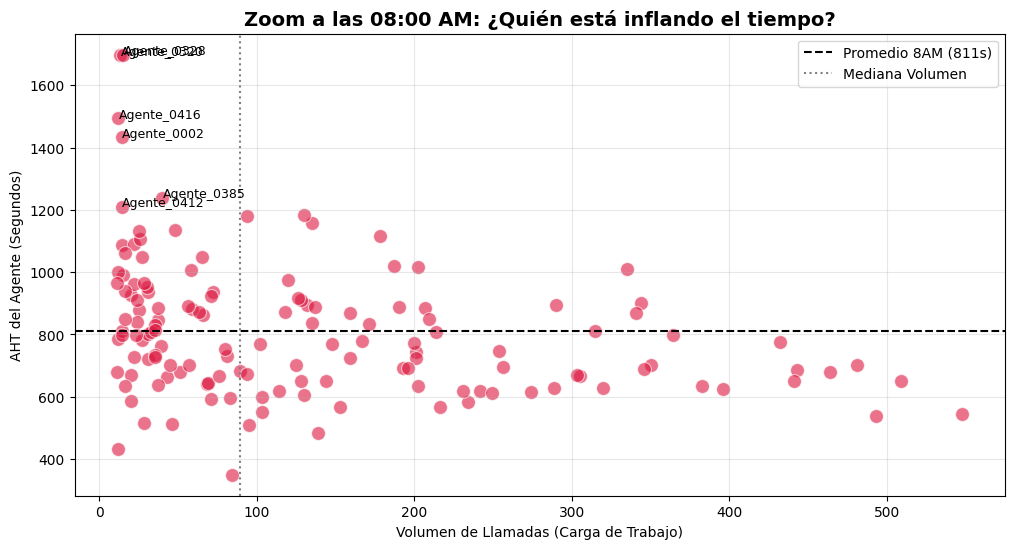

📊 Análisis de las 08:00 AM:
   -> Agentes analizados: 141
   -> AHT Promedio en esta hora: 811 seg
   -> Peor Agente (Lento): Agente_0328 con 1698 seg


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
plt.figure(figsize=(12, 6))

# 1. FILTRAR LA HORA CRÍTICA (08:00 AM)
# Queremos ver qué pasa exactamente en ese pico de 800 segundos
df_peak = df_procesado[df_procesado['Hora'] == 8]

# 2. AGRUPAR POR AGENTE (Solo datos de las 8 AM)
# Filtramos agentes con al menos 10 llamadas en esa hora para evitar ruido
agent_peak = df_peak.groupby('Agente_ID')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
agent_peak['AHT_8AM'] = agent_peak['Total_Handle_Time'] / agent_peak['Llamadas Atendidas']
agent_peak = agent_peak[agent_peak['Llamadas Atendidas'] > 10] 

# 3. SCATTER PLOT (Volumen vs AHT)
# Eje X: Cuántas llamadas toman.
# Eje Y: Cuánto tardan.
sns.scatterplot(data=agent_peak, x='Llamadas Atendidas', y='AHT_8AM', alpha=0.6, s=100, color='crimson')

# Líneas de referencia
promedio_hora = agent_peak['AHT_8AM'].mean()
plt.axhline(y=promedio_hora, color='black', linestyle='--', label=f'Promedio 8AM ({int(promedio_hora)}s)')
plt.axvline(x=agent_peak['Llamadas Atendidas'].median(), color='grey', linestyle=':', label='Mediana Volumen')

plt.title('Zoom a las 08:00 AM: ¿Quién está inflando el tiempo?', fontsize=14, fontweight='bold')
plt.xlabel('Volumen de Llamadas (Carga de Trabajo)')
plt.ylabel('AHT del Agente (Segundos)')
plt.legend()
plt.grid(True, alpha=0.3)

# Identificar outliers extremos (Etiquetas)
# Si alguien tarda más de 1200 seg (20 min) a esa hora, queremos saber su ID falso
outliers = agent_peak[agent_peak['AHT_8AM'] > 1200]
for agent_id, row in outliers.iterrows():
    plt.text(row['Llamadas Atendidas']+0.5, row['AHT_8AM'], agent_id, fontsize=9)

plt.show()

# Resumen rápido en texto
print(f"📊 Análisis de las 08:00 AM:")
print(f"   -> Agentes analizados: {len(agent_peak)}")
print(f"   -> AHT Promedio en esta hora: {int(promedio_hora)} seg")
print(f"   -> Peor Agente (Lento): {agent_peak['AHT_8AM'].idxmax()} con {int(agent_peak['AHT_8AM'].max())} seg")

In [8]:
# =========================================================
# 6. ANÁLISIS DE IMPACTO (La Recomendación de Negocio)
# =========================================================

# 1. Definir el "Umbral de Dolor" a las 8 AM
# Basado en lo que viste en el gráfico, digamos que cualquiera arriba de 1000s es crítico.
UMBRAL_CRITICO = 1000 
HORA_CRITICA = 8

# Filtramos los datos de esa hora
df_8am = df_procesado[df_procesado['Hora'] == HORA_CRITICA].copy()

# Agrupamos por agente
agentes_8am = df_8am.groupby('Agente_ID')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
agentes_8am['AHT_Real'] = agentes_8am['Total_Handle_Time'] / agentes_8am['Llamadas Atendidas']

# 2. IDENTIFICAR LOS "OUTLIERS" (Los que necesitan capacitación)
# Filtramos: AHT alto Y volumen significativo (más de 5 llamadas para descartar errores)
coaching_list = agentes_8am[
    (agentes_8am['AHT_Real'] > UMBRAL_CRITICO) & 
    (agentes_8am['Llamadas Atendidas'] > 5)
].sort_values('AHT_Real', ascending=False)

print(f"🚨 ALERTAS DETECTADAS: {len(coaching_list)} agentes críticos a las {HORA_CRITICA}:00 horas.")
display(coaching_list)

# 3. ESCENARIO "WHAT-IF" (¿Qué pasa si los capacitamos?)
# Calculamos el AHT Global Actual de las 8 AM
aht_actual_global = df_8am['Total_Handle_Time'].sum() / df_8am['Llamadas Atendidas'].sum()

# Simulamos: Si estos agentes bajaran su tiempo al promedio de la hora (digamos 720s)
# Restamos su tiempo excesivo y sumamos el tiempo "ideal"
aht_promedio_meta = 720
tiempo_excesivo = coaching_list['Total_Handle_Time'].sum()
tiempo_simulado = coaching_list['Llamadas Atendidas'].sum() * aht_promedio_meta

nuevo_tiempo_total = df_8am['Total_Handle_Time'].sum() - tiempo_excesivo + tiempo_simulado
nuevo_aht_global = nuevo_tiempo_total / df_8am['Llamadas Atendidas'].sum()

# Resultados
mejora = aht_actual_global - nuevo_aht_global
print(f"\n💰 IMPACTO DE NEGOCIO:")
print(f"   -> AHT Actual a las 8 AM: {aht_actual_global:.2f} seg")
print(f"   -> AHT Proyectado (Post-Capacitación): {nuevo_aht_global:.2f} seg")
print(f"   -> MEJORA POTENCIAL: -{mejora:.2f} segundos en el promedio global.")

🚨 ALERTAS DETECTADAS: 32 agentes críticos a las 8:00 horas.


,Total_Handle_Time,Llamadas Atendidas,AHT_Real
Agente_ID,,,
Agente_0404,21325,9,2369.444444
Agente_0328,25470,15,1698.000000
Agente_0320,22064,13,1697.230769
Agente_0418,14209,9,1578.777778
Agente_0416,17938,12,1494.833333
Agente_0415,13305,9,1478.333333
Agente_0002,20070,14,1433.571429
Agente_0106,10007,7,1429.571429
Agente_0385,49559,40,1238.975000



💰 IMPACTO DE NEGOCIO:
   -> AHT Actual a las 8 AM: 749.76 seg
   -> AHT Proyectado (Post-Capacitación): 714.92 seg
   -> MEJORA POTENCIAL: -34.84 segundos en el promedio global.


___

C:\Users\Ivan Die\AppData\Local\Temp\ipykernel_9520\3249149203.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranking_plot.index, y=ranking_plot['AHT_Agente'], palette=colors)


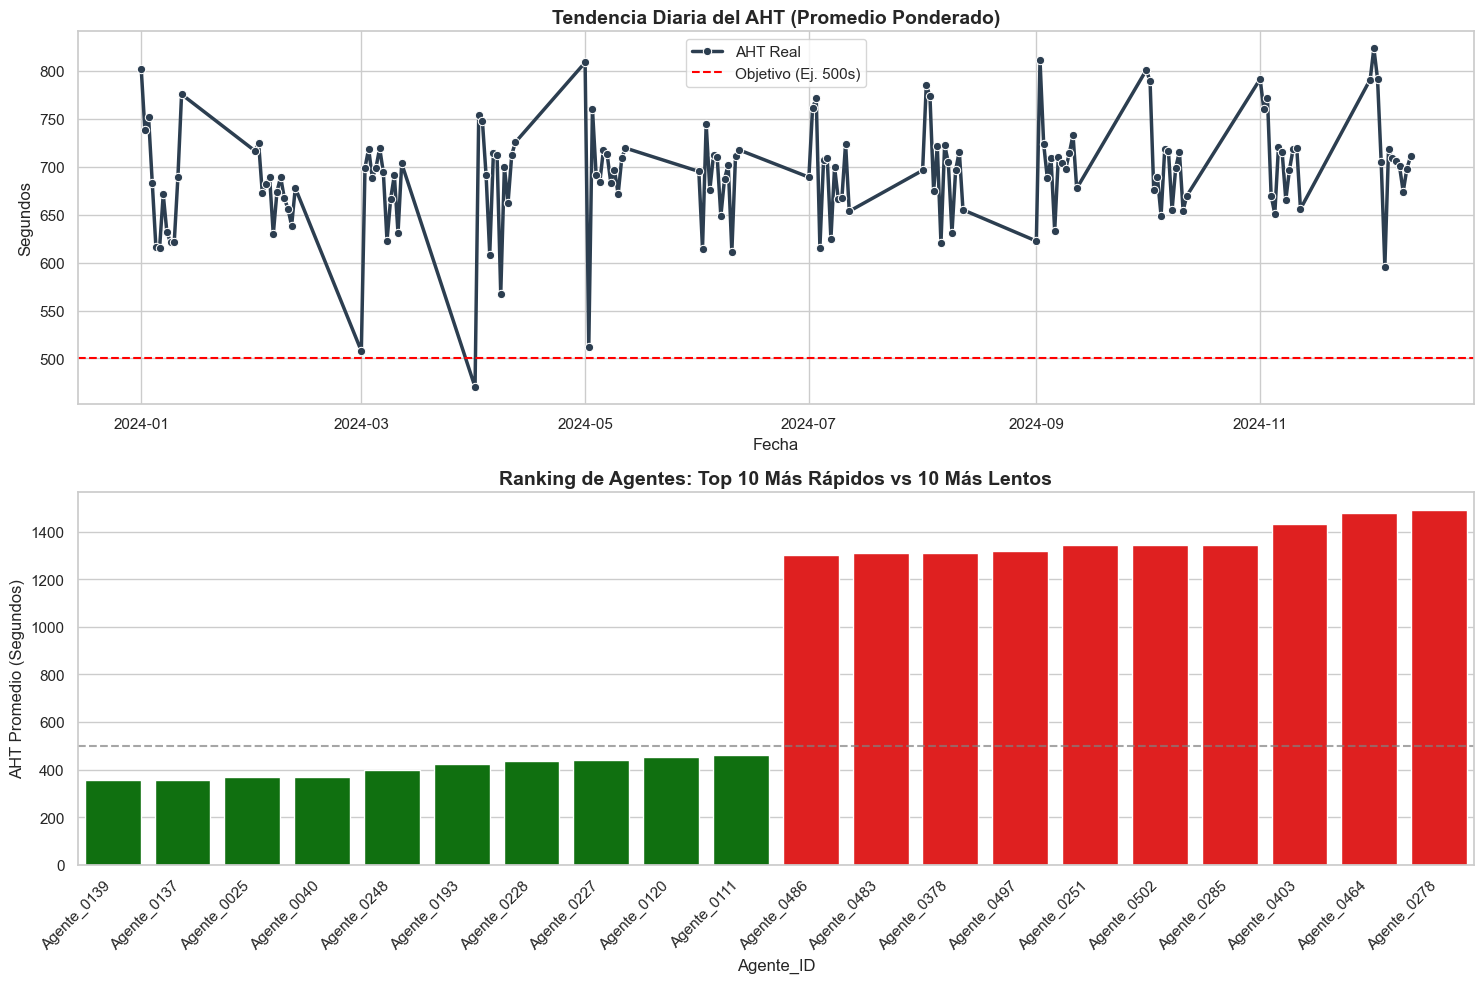

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# =========================================================
# GRÁFICO 1: TENDENCIA DIARIA (AHT Real vs Objetivo)
# =========================================================
# Agrupamos por fecha sumando los tiempos y las llamadas (Promedio Ponderado)
daily_kpis = df_procesado.groupby('Fecha')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
daily_kpis['AHT_Dia'] = daily_kpis['Total_Handle_Time'] / daily_kpis['Llamadas Atendidas']
daily_kpis = daily_kpis.reset_index()

plt.subplot(2, 1, 1)
# Línea de tendencia
sns.lineplot(data=daily_kpis, x='Fecha', y='AHT_Dia', marker='o', linewidth=2.5, color="#2c3e50", label='AHT Real')

# Agregamos una línea de referencia (Objetivo hipotético, ajusta el valor, ej. 500 seg)
plt.axhline(y=500, color='red', linestyle='--', label='Objetivo (Ej. 500s)')

plt.title('Tendencia Diaria del AHT (Promedio Ponderado)', fontsize=14, fontweight='bold')
plt.ylabel('Segundos')
plt.legend()


# =========================================================
# GRÁFICO 2: TOP & BOTTOM PERFORMERS (¿Quién mueve la aguja?)
# =========================================================
# 1. Agrupar por agente
agent_kpis = df_procesado.groupby('Agente_ID')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
agent_kpis['AHT_Agente'] = agent_kpis['Total_Handle_Time'] / agent_kpis['Llamadas Atendidas']

# 2. Filtrar agentes con volumen representativo (Ej: > 50 llamadas en el periodo)
# Esto elimina a los "fantasmas" que tomaron 1 llamada y distorsionan el ranking
agent_kpis = agent_kpis[agent_kpis['Llamadas Atendidas'] > 50].sort_values('AHT_Agente')

# 3. Seleccionar los 10 mejores (Menor AHT) y 10 peores (Mayor AHT)
top_10 = agent_kpis.head(10)
bottom_10 = agent_kpis.tail(10)
ranking_plot = pd.concat([top_10, bottom_10])

plt.subplot(2, 1, 2)
# Usamos un mapa de colores: Verde para bajos tiempos, Rojo para altos
colors = ['green']*10 + ['red']*10

sns.barplot(x=ranking_plot.index, y=ranking_plot['AHT_Agente'], palette=colors)
plt.title('Ranking de Agentes: Top 10 Más Rápidos vs 10 Más Lentos', fontsize=14, fontweight='bold')
plt.ylabel('AHT Promedio (Segundos)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=500, color='grey', linestyle='--', alpha=0.7) # Referencia

plt.tight_layout()
plt.show()